In [1]:
import torch
import sys
from architectures import MLP
from train import train_epoch, train_model, test_model, accuracy, AverageMeter
from torchinfo import summary
from torchviz import make_dot
from mnist import get_data
from torch import Tensor
import os
from torch.utils.data import DataLoader

In [2]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader = get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)
print(int(len(trainloader.dataset)))

1.4%

100.0%


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


102.8%


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw




11.3%

100.0%
112.7%


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

60000


In [3]:
learn_rate = 0.1
momentum = 0.9
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP()
model.to(device)

print(summary(model))

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       12,560
│    └─ReLU: 2-3                         --
│    └─BatchNorm1d: 2-4                  32
│    └─Linear: 2-5                       544
│    └─ReLU: 2-6                         --
│    └─BatchNorm1d: 2-7                  64
│    └─Linear: 2-8                       792
│    └─ReLU: 2-9                         --
│    └─BatchNorm1d: 2-10                 48
│    └─Linear: 2-11                      250
Total params: 14,290
Trainable params: 14,290
Non-trainable params: 0


#### Homework recap - EASTER HOMEWORK (optional)

1. Implement L1 norm regularization as a custom loss function
2. Implement L1 norm regularization as a custom optimizer
3. Implement early stopping in the $E_{\text{opt}}$ specification
4. Implement early stopping in one of the additional specifications as of [4](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf)
5. Reconstruct in PyTorch the first experiment in [Learning representations by back-propagating errors](https://www.nature.com/articles/323533a0) with learning rule in eq.8 (gradient descent without momentum)
     - Try to be as close as possible to the original protocol, except for what regards the learning rule
     - Read the paper, if you did not do it yet (don’t worry if you don’t understand the other experiments in detail)
     - Create the data, the model and everything is needed (do not use dataloaders if you don’t know how yet how they work)
     - Train the model
     - Inspect the weights you obtained and check if they provide a solution to the problem
     - Compare the solution to the solution reported in the paper
     - Do not get frustrated if the results are not as expected!


1) L1 Norm regularization as a custom loss function

In [4]:
# Here I defined the class for L1 regularization (so we can work with any loss function)
'''
Possible improvements:
- add custom L1 coefficients for each layer
'''
class L1_regularization(torch.nn.Module):
    def __init__(self, model, reg_lambda=0.1, loss_fn=None):
        super(L1_regularization, self).__init__()
        self.reg_lambda = reg_lambda
        self.L1 = self._L1_norm(model)
        self.loss_fn = loss_fn
    
    def forward(self, y_hat, y):
        loss = self.loss_fn(y_hat, y) if self.loss_fn is not None else None
        return loss + self.L1 if loss is not None else self.L1
    
    def _L1_norm(self, model):
        params = list(model.parameters())
        L1_norm = torch.norm(torch.cat([param.data.flatten() for param in params]), p=1, dim=0)
        return self.reg_lambda*L1_norm
    
    def info(self):
        print(f"L1 regularization coefficient: {self.reg_lambda}")
        print(f"Loss function associated: {self.loss_fn}")

2. Implement L1 norm regularization as a custom optimizer

In [5]:
class SGD_L1(torch.optim.Optimizer):
    '''
    An alternative of torch.optim.SGD with momentum and L1 regularization
    '''
    def __init__(self, parameters, lr:float = 0.1, momentum:float = 0, l1_reg:float = 0):
        # we skip check on the args values
        # initialize superclass with
            # parameters
            # hyperparameters as dict
        super().__init__(
            parameters,
            {
                "lr": lr,
                "momentum": momentum,
                "l1_reg": l1_reg
            }
        )

    @torch.no_grad() # -> decorator specifying that all the computations here are done without keeping the gradient
    def step(self):
        for pg in self.param_groups: # note: param_groups is already here bc it's defined in the father class
            for param in pg["params"]:
                if param.grad is not None: # param update operated only on those params having gradient
                    
                    # now we wish to recover the momentum buffer (which in the equation of SGD with momentum is indicated with M)
                    # each parameter within the optimizer group indexes a dictionary where the values are a group of entities
                    # which are crucial for the optimizer to work
                    state = self.state[param]
                    # we use .get so it does not throw an exception in case of nonexistence of the key in the dict
                    M = state.get("momentum_buffer")

                    if M is not None:
                        # if the buffer exists -> update it
                        # M = pg["momentum"] * M + pg["lr"] * param.grad
                        # ↓ more advanced notion than ↑
                        M.mul_(pg["momentum"]).add_(param.grad * pg["lr"]).add_(pg["lr"] * pg["l1_reg"] * torch.sign(param.data))
                    else:
                        # if the buffer does not exist, we must calculate the momentum and then assign it to the dict
                        # we don't use pg["momentum"] as we don't have previous values for it.
                        M = pg["lr"] * param.grad + pg["lr"] * pg["l1_reg"] * torch.sign(param.data)
                        state["momentum_buffer"] = M

                    # now we can update the params by subtracting the buffer M
                    param.sub_(M)

In [6]:
model = MLP()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_L1 = SGD_L1(model.parameters(), lr=learn_rate, momentum=momentum, l1_reg=0.001)
train_model(model, trainloader, loss_fn, optimizer_L1, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, device=device)

Epoch 1 completed. Loss - total: 24342.547091960907 - average: 0.40570911819934846; Performance: 0.8808333333333334
Epoch 2 completed. Loss - total: 14328.876857757568 - average: 0.23881461429595946; Performance: 0.92875
Epoch 3 completed. Loss - total: 13474.181285858154 - average: 0.22456968809763592; Performance: 0.9327333333333333
Epoch 4 completed. Loss - total: 13022.759751796722 - average: 0.21704599586327872; Performance: 0.9354333333333333
Epoch 5 completed. Loss - total: 12536.43040895462 - average: 0.20894050681591034; Performance: 0.9366833333333333


(12536.43040895462, 0.9366833333333333)

3. Implement early stopping in the $E_{\text{opt}}$ specification

In [7]:
def train_model_early_stopping(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, device="cuda", history=False):

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
        
    if checkpoint_name is not None:
        train_data, validation_data = split_Dataloader(dataloader, train_percentage=0.8)
    else:
        train_data = dataloader
        validation_data = None
    
    if history:
        train_history = []
        validation_history = []

    model.train()

    best_val_loss = float('inf')

    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, train_data, loss_fn, optimizer, loss_meter, performance_meter, performance, device)
        if history:
            train_history.append(performance_meter.avg)

        print(f"Epoch {epoch+1} completed. Loss - total: {round(loss_meter.sum, 0)} - average: {round(loss_meter.avg, 3)}; Performance: {round(performance_meter.avg, 3)}")

        if checkpoint_name is not None:
            curr_total_loss = test_model(model, validation_data, performance, loss_fn, device)
            if curr_total_loss[0] < best_val_loss:       # early stopping condition
                checkpoint_dict = {
                    "parameters": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "best_loss_meter_over_validation": {'total': curr_total_loss[0], 'avg': curr_total_loss[1]},
                    "best_performance_meter": {'avg': curr_total_loss[2]}
                }
                torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))  # save the checkpoint
                best_val_loss = curr_total_loss[0]          # update the best loss
        
        if history:
            validation_history.append(curr_total_loss[2])

    if checkpoint_name is not None:
        filename = os.path.join(checkpoint_loc, checkpoint_name)
        
        keys_metric = ["epoch", "best_loss_meter_over_validation", "best_performance_meter"]
        model.load_state_dict(torch.load(filename)["parameters"])       # load the best model
        optimizer.load_state_dict(torch.load(filename)["optimizer"])     # load the best optimizer
        
        if history:
            return metrics(filename, keys_metric), train_history, validation_history
        return metrics(filename, keys_metric)                           # return and print the metrics


    else:
        if history:
            return loss_meter.sum, loss_meter.avg, performance_meter.avg, train_history
        return loss_meter.sum, loss_meter.avg, performance_meter.avg

def metrics(filename, keys_metric):                                     # custom function for the metrics
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    best_epoch, best_loss_meter, best_performance_meter = dictfilt(torch.load(filename), keys_metric).values()
    print(f"\nBEST METRICS OVER VALIDATION\n" +
            f"Epoch {best_epoch+1}; Loss - total: {round(best_loss_meter['total'], 0)} - average: {round(best_loss_meter['avg'], 3)}; Performance: {round(best_performance_meter['avg'], 3)}")
    
    return best_epoch+1, best_loss_meter['total'], best_loss_meter['avg'], best_performance_meter['avg']

def split_Dataloader(dataloader, train_percentage:float):               # custom function for splitting the dataloader in train set and validation set
    train_size = int(len(dataloader.dataset)*train_percentage)
    train_data, test_data = torch.utils.data.random_split(dataloader.dataset, [train_size, int(len(dataloader.dataset)-train_size)])
    train_dataloader = DataLoader(train_data, batch_size=dataloader.batch_size, shuffle=False, num_workers=dataloader.num_workers)
    test_dataloader = DataLoader(test_data, batch_size=dataloader.batch_size, shuffle=False, num_workers=dataloader.num_workers)
    return train_dataloader, test_dataloader

In [8]:
checkpoint_loc = "/home/yuri/Scrivania/DS_SC/2nd_SEM/Deep_Learning/Lessons - Code/models/checkpoints"
model = MLP()
model.to(device)
num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)
metrcs, train_history, validation_history = train_model_early_stopping(model, trainloader, loss_fn, 
                                                                         optimizer, num_epochs, checkpoint_loc=checkpoint_loc, 
                                                                         checkpoint_name="checkpoint.pt", performance=accuracy, 
                                                                         device=device, history=True)

Epoch 1 completed. Loss - total: 21324.0 - average: 0.444; Performance: 0.868
TESTING - total loss: 2576.0 average loss: 0.215- performance 0.934

Epoch 2 completed. Loss - total: 9155.0 - average: 0.191; Performance: 0.941
TESTING - total loss: 2330.0 average loss: 0.194- performance 0.939

Epoch 3 completed. Loss - total: 7813.0 - average: 0.163; Performance: 0.949
TESTING - total loss: 2154.0 average loss: 0.179- performance 0.946

Epoch 4 completed. Loss - total: 6882.0 - average: 0.143; Performance: 0.954
TESTING - total loss: 2052.0 average loss: 0.171- performance 0.947

Epoch 5 completed. Loss - total: 6278.0 - average: 0.131; Performance: 0.959
TESTING - total loss: 1957.0 average loss: 0.163- performance 0.95

Epoch 6 completed. Loss - total: 5856.0 - average: 0.122; Performance: 0.962
TESTING - total loss: 1931.0 average loss: 0.161- performance 0.951

Epoch 7 completed. Loss - total: 5511.0 - average: 0.115; Performance: 0.965
TESTING - total loss: 1974.0 average loss: 0.16

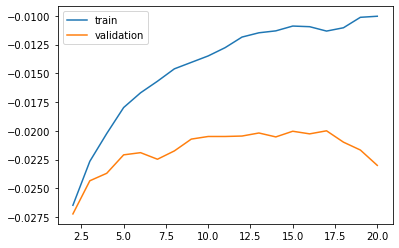

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(range(2, len(train_history)+1), np.log10(train_history[1:]), label="train")
plt.plot(range(2, len(validation_history)+1), np.log10(validation_history[1:]), label="validation")
plt.legend()
plt.show()